In [189]:
import io
import gzip
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import requests
from sklearn import cluster, manifold, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import umap
# Silence perf warning
import warnings

import nodevectors as graph2vec
import csrgraph

warnings.simplefilter("ignore")

In [2]:
def make_blogcatalog(edgelist='../data/BlogCatalog/edges.csv',
                    labels='../data/BlogCatalog/node_lable.csv',
                    dedupe=True):
    """
    Graph with cluster labels from blogcatalog
    
    Dedupe: Whether to deduplicate results (else some nodes have multilabels)
    """
    G = nx.read_edgelist(edgelist, delimiter=',')
    labels = pd.read_csv(labels, header=None)
    labels.columns = ['node', 'label']
    labels = labels.sort_values(by='node').reset_index(drop=True)
    if dedupe:
        labels = labels.loc[~labels.node.duplicated()
                      ].reset_index(drop=True)
    labels.node = labels.node.astype(int)
    labels.label = labels.label.astype(int)
    return G, labels

def make_snap():
    """
    Graph from university emails, clustered by departments
    Data from http://snap.stanford.edu/data/email-Eu-core.html
    Edge list Format
    """
    edges = pd.read_csv('../data/emails/email-Eu-core.txt', header=None, sep=' ')
    edges.columns = ['src', 'dest']
    # cluster labels per node
    labels = pd.read_csv('../data/emails/email-Eu-core-department-labels.txt', header=None, sep=' ')
    labels.columns = ['node', 'cluster']
    G = nx.Graph()
    G.add_edges_from([(t.src, t.dest) for t in edges.itertuples()])
    return G, pd.DataFrame({'node': list(G), 'label': labels.cluster})

def make_karate():
    """
    Graph from karate dataset
    """
    G = nx.karate_club_graph()
    labels.columns = ['node', 'cluster']
    
    
    return G, pd.DataFrame({'node': list(G), 'label': labels.cluster})


In [307]:
G_karate = nx.karate_club_graph()
labels = pd.DataFrame(columns=['node', 'cluster'])

for i in list(G_karate.nodes):
    df1 = pd.DataFrame({i:[0 if G_karate.node[i]['club']== 'Mr. Hi' else 1]}) 
    labels.append(df1)


print(labels)

Empty DataFrame
Columns: [node, cluster]
Index: []


In [3]:
def evalClusteringOnLabels(clusters, groupLabels, verbose=True):
    results = []
    results.append(metrics.adjusted_mutual_info_score(clusters, groupLabels))
    results.append(metrics.adjusted_rand_score(clusters, groupLabels))
    results.append(metrics.fowlkes_mallows_score(clusters, groupLabels))
    if verbose:
        print("adj. MI score:   {0:.2f}".format(results[0]))
        print("adj. RAND score: {0:.2f}".format(results[1]))
        print("F-M score:       {0:.2f}".format(results[2]))
    return np.array(results)

def to_X(node_labels, embedder):
    """
    Takes a series of node names and returns matrix of embeddings
    """
    X = pd.DataFrame.from_records(
        node_labels.astype(type(list(G)[0])).apply(embedder.predict).values)
    return X

In [448]:
# G, labels = make_blogcatalog(dedupe=True)
G, labels = make_snap()

y = labels.label
n_clusters = y.nunique()

# Gridsearch result table
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

X_train, X_test, y_train, y_test = train_test_split(
    labels.node, labels.label, test_size=0.10, 
    random_state=33)

In [300]:
type(labels)

pandas.core.frame.DataFrame

In [160]:
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

for WALKLEN in [80]: # l in paper
 for EPOCH in [10]: # r in paper for EPOCH in [6,8,10,12,14,16,18,20]:
  for N_WEIGHT in [1.]: #  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: q in paper 
   for R_WEIGHT in [1.]: # for R_WEIGHT in [0.3, 1., 3.]: p in paper
    for WINDOW in [1,2,4,6]: # k in paper for WINDOW in [10]:
     for EMBED_SIZE in [128]: # d in paper
      for NS_EXP in [0.75]: # default, not in paper
       for NEGATIVE in [5]: # default, not in paper
        start_t = time.time()
        print('WALKLEN ',WALKLEN)
        embedder = graph2vec.Node2Vec(
            walklen=WALKLEN,
            epochs=EPOCH,
            return_weight=R_WEIGHT,
            neighbor_weight=N_WEIGHT,
            n_components=EMBED_SIZE,
            w2vparams={'window': WINDOW,
                       'negative': NEGATIVE, 
                       'iter': 5,
                       'ns_exponent': NS_EXP,
                       'batch_words': 128}
        )
        embedder.fit(G)
        train_t = time.time()
        print(f"Fit Embedder: {time.time() - start_t:.2f}")
        logit = linear_model.LogisticRegressionCV(cv=5, scoring='f1_macro',
                                                  max_iter=3000,
                                                  solver='lbfgs',
                                                  multi_class='ovr')
        X_full = to_X(labels.node, embedder=embedder)
        scaler = StandardScaler().fit(X_full)
        logit.fit(scaler.transform(to_X(X_train, embedder=embedder)), y_train)
        score = logit.scores_[1].mean(axis=0).max()
        print(f"Trained: {time.time() - start_t:.2f}")
        print(f'best CV score: {score :.4f}')
        test_score = metrics.f1_score(
            y_true=y_test,
            y_pred=logit.predict(scaler.transform(to_X(X_test, embedder=embedder))),
            average='macro'
        )
        print(f"test score: {test_score :.4f}")
        
#         assigned_clusters = cluster.AgglomerativeClustering(
#             n_clusters=n_clusters, 
#             affinity='cosine', 
#             linkage='average'
#         ).fit(X_full).labels_

        assigned_clusters = cluster.KMeans(
            n_clusters=n_clusters, 
            random_state=25
        ).fit(X_full).labels_

        x = evalClusteringOnLabels(assigned_clusters, labels.label)
        print("-------------------\n\n")

        res = res.append({
            'params':{
                'walklen': WALKLEN,
                'epochs': EPOCH,
                'return_weight': R_WEIGHT,
                'neighbor_weight': N_WEIGHT,
                'window': WINDOW,
                'size': EMBED_SIZE, 
                'negative': NEGATIVE, 
                'iter': EPOCH,
                'ns_exponent': NS_EXP,
                'batch_words': 128,
            }, 
            'traintime': train_t - start_t, 
            'F1': score, 
            'F1_test': test_score,
            'MI':x[0], 
            'RAND':x[1], 
            'F-M':x[2]}, 
            ignore_index=True)

WALKLEN  80
Making walks... Done, T=0.09
Mapping Walk Names... Done, T=1.00
Training W2V... 

KeyboardInterrupt: 

In [31]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime('%Y%m%d-%H%M%S_emails_EPOCH')
filename = '../results/' + current_time + '.csv'
res.to_csv(filename)

In [33]:
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

for WALKLEN in [80]: # l in paper
 for EPOCH in [10]: # r in paper for EPOCH in [6,8,10,12,14,16,18,20]:
  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: #  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: q in paper 
   for R_WEIGHT in [1.]: # for R_WEIGHT in [0.3, 1., 3.]: p in paper
    for WINDOW in [10]: # k in paper for WINDOW in [10]:
     for EMBED_SIZE in [128]: # d in paper
      for NS_EXP in [0.75]: # default, not in paper
       for NEGATIVE in [5]: # default, not in paper
        start_t = time.time()
        print('WALKLEN ',WALKLEN)
        embedder = graph2vec.Node2Vec(
            walklen=WALKLEN,
            epochs=EPOCH,
            return_weight=R_WEIGHT,
            neighbor_weight=N_WEIGHT,
            n_components=EMBED_SIZE,
            w2vparams={'window': WINDOW,
                       'negative': NEGATIVE, 
                       'iter': 5,
                       'ns_exponent': NS_EXP,
                       'batch_words': 128}
        )
        embedder.fit(G)
        train_t = time.time()
        print(f"Fit Embedder: {time.time() - start_t:.2f}")
        logit = linear_model.LogisticRegressionCV(cv=5, scoring='f1_macro',
                                                  max_iter=3000,
                                                  solver='lbfgs',
                                                  multi_class='ovr')
        X_full = to_X(labels.node, embedder=embedder)
        scaler = StandardScaler().fit(X_full)
        logit.fit(scaler.transform(to_X(X_train, embedder=embedder)), y_train)
        score = logit.scores_[1].mean(axis=0).max()
        print(f"Trained: {time.time() - start_t:.2f}")
        print(f'best CV score: {score :.4f}')
        test_score = metrics.f1_score(
            y_true=y_test,
            y_pred=logit.predict(scaler.transform(to_X(X_test, embedder=embedder))),
            average='macro'
        )
        print(f"test score: {test_score :.4f}")
        
#         assigned_clusters = cluster.AgglomerativeClustering(
#             n_clusters=n_clusters, 
#             affinity='cosine', 
#             linkage='average'
#         ).fit(X_full).labels_

        assigned_clusters = cluster.KMeans(
            n_clusters=n_clusters, 
            random_state=25
        ).fit(X_full).labels_

        x = evalClusteringOnLabels(assigned_clusters, labels.label)
        print("-------------------\n\n")

        res = res.append({
            'params':{
                'walklen': WALKLEN,
                'epochs': EPOCH,
                'return_weight': R_WEIGHT,
                'neighbor_weight': N_WEIGHT,
                'window': WINDOW,
                'size': EMBED_SIZE, 
                'negative': NEGATIVE, 
                'iter': EPOCH,
                'ns_exponent': NS_EXP,
                'batch_words': 128,
            }, 
            'traintime': train_t - start_t, 
            'F1': score, 
            'F1_test': test_score,
            'MI':x[0], 
            'RAND':x[1], 
            'F-M':x[2]}, 
            ignore_index=True)
        

now = datetime.now()
current_time = now.strftime('%Y%m%d-%H%M%S_emails_N_WEIGHT')
filename = '../results/' + current_time + '.csv'
res.to_csv(filename)

WALKLEN  80
Making walks... Done, T=34.35
Mapping Walk Names... Done, T=1.82
Training W2V... Done, T=12.92
Fit Embedder: 49.20
Trained: 174.84
best CV score: 0.8523
test score: 0.4741
adj. MI score:   0.58
adj. RAND score: 0.36
F-M score:       0.39
-------------------


WALKLEN  80
Making walks... Done, T=33.71
Mapping Walk Names... Done, T=1.91
Training W2V... Done, T=11.80
Fit Embedder: 47.62
Trained: 189.02
best CV score: 0.8564
test score: 0.4640
adj. MI score:   0.56
adj. RAND score: 0.29
F-M score:       0.32
-------------------


WALKLEN  80
Making walks... Done, T=0.19
Mapping Walk Names... Done, T=1.54
Training W2V... Done, T=12.44
Fit Embedder: 14.26
Trained: 149.93
best CV score: 0.8609
test score: 0.5294
adj. MI score:   0.53
adj. RAND score: 0.22
F-M score:       0.27
-------------------


WALKLEN  80
Making walks... Done, T=37.09
Mapping Walk Names... Done, T=1.70
Training W2V... Done, T=11.23
Fit Embedder: 50.21
Trained: 215.81
best CV score: 0.8369
test score: 0.4436
a

In [34]:
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

for WALKLEN in [80]: # l in paper
 for EPOCH in [10]: # r in paper for EPOCH in [6,8,10,12,14,16,18,20]:
  for N_WEIGHT in [1.]: #  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: q in paper 
   for R_WEIGHT in [0.25, 0.5, 1., 2., 4]: # for R_WEIGHT in [0.3, 1., 3.]: p in paper
    for WINDOW in [10]: # k in paper for WINDOW in [10]:
     for EMBED_SIZE in [128]: # d in paper
      for NS_EXP in [0.75]: # default, not in paper
       for NEGATIVE in [5]: # default, not in paper
        start_t = time.time()
        print('WALKLEN ',WALKLEN)
        embedder = graph2vec.Node2Vec(
            walklen=WALKLEN,
            epochs=EPOCH,
            return_weight=R_WEIGHT,
            neighbor_weight=N_WEIGHT,
            n_components=EMBED_SIZE,
            w2vparams={'window': WINDOW,
                       'negative': NEGATIVE, 
                       'iter': 5,
                       'ns_exponent': NS_EXP,
                       'batch_words': 128}
        )
        embedder.fit(G)
        train_t = time.time()
        print(f"Fit Embedder: {time.time() - start_t:.2f}")
        logit = linear_model.LogisticRegressionCV(cv=5, scoring='f1_macro',
                                                  max_iter=3000,
                                                  solver='lbfgs',
                                                  multi_class='ovr')
        X_full = to_X(labels.node, embedder=embedder)
        scaler = StandardScaler().fit(X_full)
        logit.fit(scaler.transform(to_X(X_train, embedder=embedder)), y_train)
        score = logit.scores_[1].mean(axis=0).max()
        print(f"Trained: {time.time() - start_t:.2f}")
        print(f'best CV score: {score :.4f}')
        test_score = metrics.f1_score(
            y_true=y_test,
            y_pred=logit.predict(scaler.transform(to_X(X_test, embedder=embedder))),
            average='macro'
        )
        print(f"test score: {test_score :.4f}")
        
#         assigned_clusters = cluster.AgglomerativeClustering(
#             n_clusters=n_clusters, 
#             affinity='cosine', 
#             linkage='average'
#         ).fit(X_full).labels_

        assigned_clusters = cluster.KMeans(
            n_clusters=n_clusters, 
            random_state=25
        ).fit(X_full).labels_

        x = evalClusteringOnLabels(assigned_clusters, labels.label)
        print("-------------------\n\n")

        res = res.append({
            'params':{
                'walklen': WALKLEN,
                'epochs': EPOCH,
                'return_weight': R_WEIGHT,
                'neighbor_weight': N_WEIGHT,
                'window': WINDOW,
                'size': EMBED_SIZE, 
                'negative': NEGATIVE, 
                'iter': EPOCH,
                'ns_exponent': NS_EXP,
                'batch_words': 128,
            }, 
            'traintime': train_t - start_t, 
            'F1': score, 
            'F1_test': test_score,
            'MI':x[0], 
            'RAND':x[1], 
            'F-M':x[2]}, 
            ignore_index=True)
        

now = datetime.now()
current_time = now.strftime('%Y%m%d-%H%M%S_emails_R_WEIGHT')
filename = '../results/' + current_time + '.csv'
res.to_csv(filename)

WALKLEN  80
Making walks... Done, T=36.19
Mapping Walk Names... Done, T=2.00
Training W2V... Done, T=12.12
Fit Embedder: 50.53
Trained: 201.69
best CV score: 0.8462
test score: 0.5090
adj. MI score:   0.54
adj. RAND score: 0.21
F-M score:       0.26
-------------------


WALKLEN  80
Making walks... Done, T=36.39
Mapping Walk Names... Done, T=1.75
Training W2V... Done, T=12.55
Fit Embedder: 50.77
Trained: 201.80
best CV score: 0.8504
test score: 0.5309
adj. MI score:   0.54
adj. RAND score: 0.24
F-M score:       0.27
-------------------


WALKLEN  80
Making walks... Done, T=0.19
Mapping Walk Names... Done, T=1.76
Training W2V... Done, T=11.35
Fit Embedder: 13.39
Trained: 162.02
best CV score: 0.8477
test score: 0.5350
adj. MI score:   0.54
adj. RAND score: 0.22
F-M score:       0.26
-------------------


WALKLEN  80
Making walks... Done, T=38.17
Mapping Walk Names... Done, T=1.86
Training W2V... Done, T=11.89
Fit Embedder: 52.13
Trained: 203.31
best CV score: 0.8732
test score: 0.4840
a

In [449]:
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

for WALKLEN in [80]: # l in paper
 for EPOCH in [10]: # r in paper for EPOCH in [6,8,10,12,14,16,18,20]:
  for N_WEIGHT in [1.]: #  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: q in paper 
   for R_WEIGHT in [1.]: # for R_WEIGHT in [0.3, 1., 3.]: p in paper
    for WINDOW in [10]: # k in paper for WINDOW in [10]:
     for EMBED_SIZE in [8,16,32,64,128]: # d in paper
      for NS_EXP in [0.75]: # default, not in paper
       for NEGATIVE in [5]: # default, not in paper
        start_t = time.time()
        print('WALKLEN ',WALKLEN)
        embedder = graph2vec.Node2Vec(
            walklen=WALKLEN,
            epochs=EPOCH,
            return_weight=R_WEIGHT,
            neighbor_weight=N_WEIGHT,
            n_components=EMBED_SIZE,
            w2vparams={'window': WINDOW,
                       'negative': NEGATIVE, 
                       'iter': 5,
                       'ns_exponent': NS_EXP,
                       'batch_words': 128}
        )
        embedder.fit(G)
        train_t = time.time()
        print(f"Fit Embedder: {time.time() - start_t:.2f}")
        logit = linear_model.LogisticRegressionCV(cv=5, scoring='f1_macro',
                                                  max_iter=3000,
                                                  solver='lbfgs',
                                                  multi_class='ovr')
        X_full = to_X(labels.node, embedder=embedder)
        scaler = StandardScaler().fit(X_full)
        logit.fit(scaler.transform(to_X(X_train, embedder=embedder)), y_train)
        score = logit.scores_[1].mean(axis=0).max()
        print(f"Trained: {time.time() - start_t:.2f}")
        print(f'best CV score: {score :.4f}')
        test_score = metrics.f1_score(
            y_true=y_test,
            y_pred=logit.predict(scaler.transform(to_X(X_test, embedder=embedder))),
            average='macro'
        )
        print(f"test score: {test_score :.4f}")
        
#         assigned_clusters = cluster.AgglomerativeClustering(
#             n_clusters=n_clusters, 
#             affinity='cosine', 
#             linkage='average'
#         ).fit(X_full).labels_

        assigned_clusters = cluster.KMeans(
            n_clusters=n_clusters, 
            random_state=25
        ).fit(X_full).labels_

        x = evalClusteringOnLabels(assigned_clusters, labels.label)
        print("-------------------\n\n")

        res = res.append({
            'params':{
                'walklen': WALKLEN,
                'epochs': EPOCH,
                'return_weight': R_WEIGHT,
                'neighbor_weight': N_WEIGHT,
                'window': WINDOW,
                'size': EMBED_SIZE, 
                'negative': NEGATIVE, 
                'iter': EPOCH,
                'ns_exponent': NS_EXP,
                'batch_words': 128,
            }, 
            'traintime': train_t - start_t, 
            'F1': score, 
            'F1_test': test_score,
            'MI':x[0], 
            'RAND':x[1], 
            'F-M':x[2]}, 
            ignore_index=True)
        

now = datetime.now()
current_time = now.strftime('%Y%m%d-%H%M%S_emails_EMBED_SIZE')
filename = '../results/' + current_time + '.csv'
res.to_csv(filename)

WALKLEN  80
Making walks... Done, T=0.18
Mapping Walk Names... Done, T=1.33
Training W2V... Done, T=9.01
Fit Embedder: 10.73
Trained: 21.44
best CV score: 0.7737
test score: 0.3552
adj. MI score:   0.51
adj. RAND score: 0.30
F-M score:       0.34
-------------------


WALKLEN  80
Making walks... Done, T=0.15
Mapping Walk Names... Done, T=1.15
Training W2V... Done, T=8.95
Fit Embedder: 10.31
Trained: 24.16
best CV score: 0.8057
test score: 0.4250
adj. MI score:   0.53
adj. RAND score: 0.29
F-M score:       0.33
-------------------


WALKLEN  80
Making walks... Done, T=0.19
Mapping Walk Names... Done, T=1.17
Training W2V... Done, T=9.35
Fit Embedder: 10.78
Trained: 31.82
best CV score: 0.8464
test score: 0.4707
adj. MI score:   0.52
adj. RAND score: 0.20
F-M score:       0.24
-------------------


WALKLEN  80
Making walks... Done, T=0.19
Mapping Walk Names... Done, T=1.22
Training W2V... Done, T=11.18
Fit Embedder: 12.65
Trained: 57.60
best CV score: 0.8609
test score: 0.5004
adj. MI sco

In [450]:
res_walklen = pd.read_csv('../results/20200408-110112_emails_WALKLEN.csv')
res_epoch = pd.read_csv('../results/20200408-115237_emails_EPOCH.csv')
res_n_weight = pd.read_csv('../results/20200408-120901_emails_N_WEIGHT.csv')
res_r_weight = pd.read_csv('../results/20200408-122511_emails_R_WEIGHT.csv')
res_window = pd.read_csv('../results/20200408-124654_emails_WINDOW.csv')
res_EMBED_SIZE = pd.read_csv('../results/20200410-080504_emails_EMBED_SIZE.csv')

In [458]:
x1 = [40,50,60,70,80,90,100]
y1_1 = res_walklen['F1_test'].tolist()
y1_2 = res_walklen['RAND'].tolist()

x2 = [6,8,10,12,14,16,18,20]
y2_1 = res_epoch['F1_test'].tolist()
y2_2 = res_epoch['RAND'].tolist()

x3 = [0.25,0.5,1.,2.,4.]
y3_1 = res_n_weight['F1_test'].tolist()
y3_2 = res_n_weight['RAND'].tolist()

x4 = [0.25,0.5,1.,2.,4.]
y4_1 = res_r_weight['F1_test'].tolist()
y4_2 = res_r_weight['RAND'].tolist()

x5 = [6,8,10,12,14,16,18,20]
y5_1 = res_window['F1_test'].tolist()
y5_2 = res_window['RAND'].tolist()

x6 = [8,16,32,64,128]
y6_1 = res_EMBED_SIZE['F1_test'].tolist()
y6_2 = res_EMBED_SIZE['RAND'].tolist()

Text(0, 0.5, 'score')

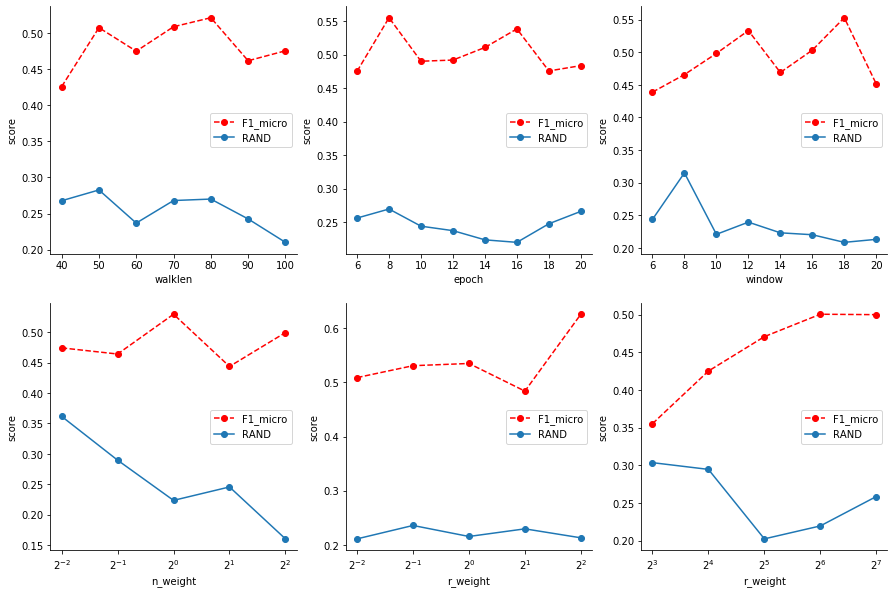

In [461]:
plt.figure(figsize=[15,10])

plt.subplot(231)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x1,y1_1,'ro--', label='F1_micro')
plt.plot(x1,y1_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('walklen')
plt.ylabel('score')

plt.subplot(232)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x2,y2_1,'ro--', label='F1_micro')
plt.plot(x2,y2_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('epoch')
plt.ylabel('score')

plt.subplot(233)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x5,y5_1,'ro--', label='F1_micro')
plt.plot(x5,y5_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('window')
plt.ylabel('score')

plt.subplot(234)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x3,y3_1,'ro--', label='F1_micro')
plt.plot(x3,y3_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='right', frameon=True)
plt.xlabel('n_weight')
plt.ylabel('score')

plt.subplot(235)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x4,y4_1,'ro--', label='F1_micro')
plt.plot(x4,y4_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='right', frameon=True)
plt.xlabel('r_weight')
plt.ylabel('score')

plt.subplot(236)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x6,y6_1,'ro--', label='F1_micro')
plt.plot(x6,y6_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='right', frameon=True)
plt.xlabel('r_weight')
plt.ylabel('score')


Parametres sensitivity study on the emails dataset; parametres beside the studied one are default.

Text(0, 0.5, 'score')

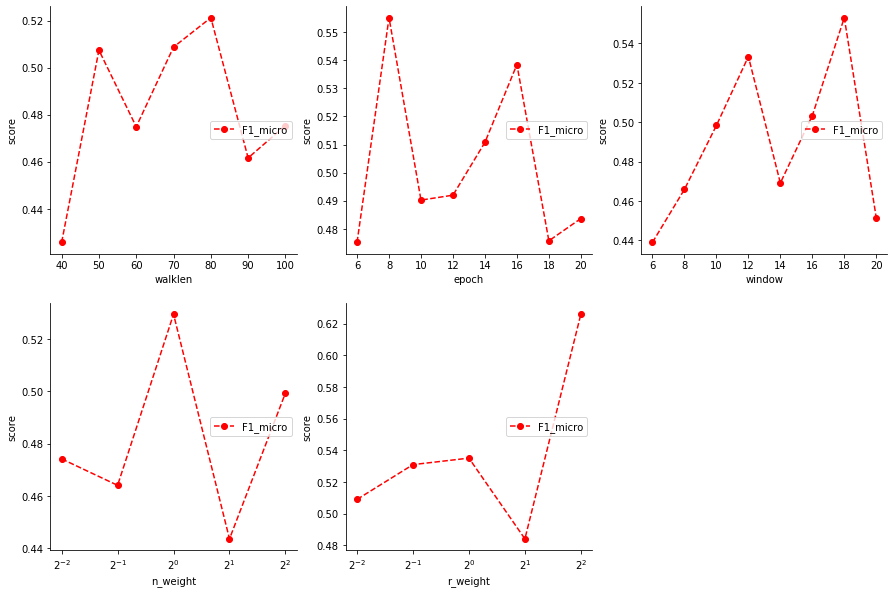

In [333]:
plt.figure(figsize=[15,10])

plt.subplot(231)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x1,y1_1,'ro--', label='F1_micro')
# plt.plot(x1,y1_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('walklen')
plt.ylabel('score')

plt.subplot(232)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x2,y2_1,'ro--', label='F1_micro')
# plt.plot(x2,y2_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('epoch')
plt.ylabel('score')

plt.subplot(233)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x5,y5_1,'ro--', label='F1_micro')
# plt.plot(x5,y5_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('window')
plt.ylabel('score')

plt.subplot(234)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x3,y3_1,'ro--', label='F1_micro')
# plt.plot(x3,y3_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='right', frameon=True)
plt.xlabel('n_weight')
plt.ylabel('score')

plt.subplot(235)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x4,y4_1,'ro--', label='F1_micro')
# plt.plot(x4,y4_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='right', frameon=True)
plt.xlabel('r_weight')
plt.ylabel('score')

Same as the previous one, but with f1_micro score only

In [220]:
karate_best = pd.read_csv('../results/20200406-183549_karate_results.csv')

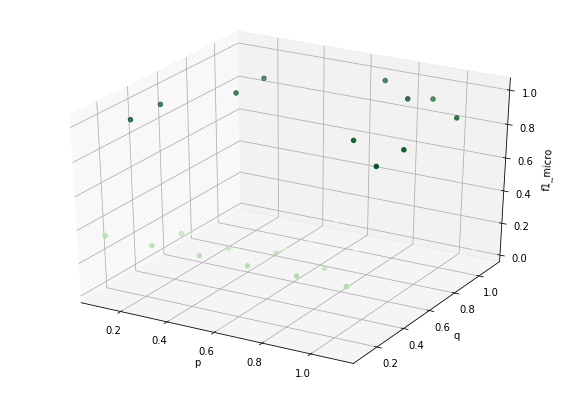

In [249]:
# p x q; walk_length=70, num_walks=24
fig= plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

ax.scatter3D(karate_best['p'], karate_best['q'], karate_best['f1_micro'],c=karate_best['f1_micro'], cmap='Greens');
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('f1_micro');

P and Q parametres sensitivity study on the karate dataset; 

I have tried to find the best parametres here, which are walk_len = 70 and num_walks = 24

p and q are [0.1, 0.3, 0.5, 0.7, 0.9, 1.1]

In [252]:
karate = pd.read_csv('../results/20200401-163231_karate_results.csv')

In [253]:
karate_p = karate.loc[(karate['walk_length']==80) & (karate['num_walks']==10) & (karate['q']==1.0), 
                 ['p','f1_micro','adj_rand_score'] ].reset_index()
karate_q = karate.loc[(karate['walk_length']==80) & (karate['num_walks']==10) & (karate['p']==1.0), 
                 ['q','f1_micro','adj_rand_score'] ].reset_index()
karate_walklen = karate.loc[(karate['num_walks']==10) & (karate['p']==1.0) & (karate['q']==1.0), 
                 ['walk_length','f1_micro','adj_rand_score'] ].reset_index()
karate_numwalk = karate.loc[(karate['walk_length']==80) & (karate['p']==1.0) & (karate['q']==1.0), 
                 ['num_walks','f1_micro','adj_rand_score'] ].reset_index()

Text(0, 0.5, 'score')

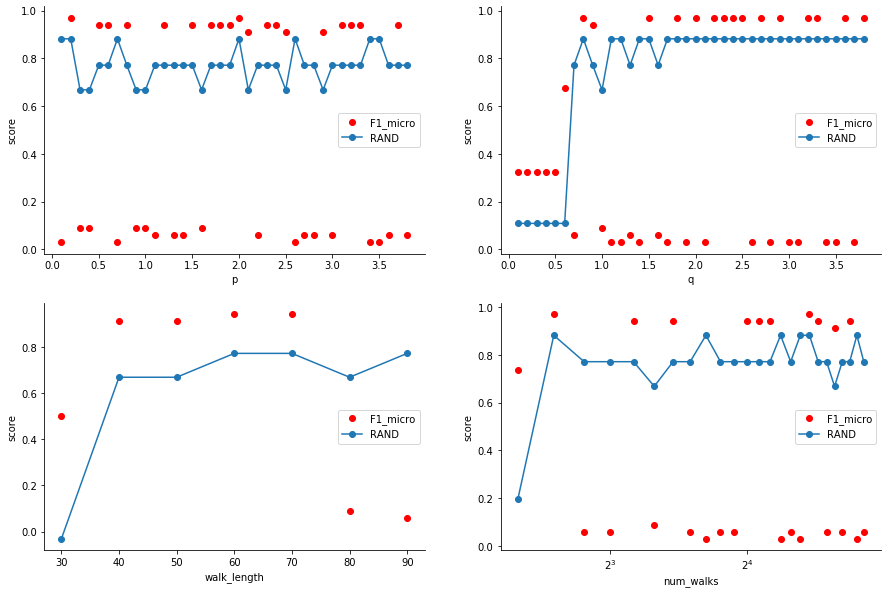

In [339]:
plt.figure(figsize=[15,10])

plt.subplot(221)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(karate_p['p'],karate_p['f1_micro'],'ro', label='F1_micro')
plt.plot(karate_p['p'],karate_p['adj_rand_score'],'o-',label='RAND')
plt.legend(loc=5, frameon=True)
plt.xlabel('p')
plt.ylabel('score')

plt.subplot(222)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(karate_q['q'],karate_q['f1_micro'],'ro', label='F1_micro')
plt.plot(karate_q['q'],karate_q['adj_rand_score'],'o-',label='RAND')
plt.legend(loc=5, frameon=True)
plt.xlabel('q')
plt.ylabel('score')

plt.subplot(223)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(karate_walklen['walk_length'],karate_walklen['f1_micro'],'ro', label='F1_micro')
plt.plot(karate_walklen['walk_length'],karate_walklen['adj_rand_score'],'o-',label='RAND')
plt.legend(loc=5, frameon=True)
plt.xlabel('walk_length')
plt.ylabel('score')

plt.subplot(224)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(karate_numwalk['num_walks'],karate_numwalk['f1_micro'],'ro', label='F1_micro')
plt.plot(karate_numwalk['num_walks'],karate_numwalk['adj_rand_score'],'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc=5, frameon=True)
plt.xlabel('num_walks')
plt.ylabel('score')


Parametres sensitivity study on the karate dataset; parametres beside the studied one are default.

In [309]:
G, labels = make_blogcatalog(dedupe=True)
# G, labels = make_snap()

y = labels.label
n_clusters = y.nunique()

# Gridsearch result table
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

X_train, X_test, y_train, y_test = train_test_split(
    labels.node, labels.label, test_size=0.10, 
    random_state=33)

In [310]:
len(G)

10312

In [311]:
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

for WALKLEN in [80]: # l in paper
 for EPOCH in [6,8,10,12,14,16,18,20]: # r in paper for EPOCH in [6,8,10,12,14,16,18,20]:
  for N_WEIGHT in [1.]: #  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: q in paper 
   for R_WEIGHT in [1.]: # for R_WEIGHT in [0.3, 1., 3.]: p in paper
    for WINDOW in [10]: # k in paper for WINDOW in [10]:
     for EMBED_SIZE in [128]: # d in paper
      for NS_EXP in [0.75]: # default, not in paper
       for NEGATIVE in [5]: # default, not in paper
        start_t = time.time()
        print('WALKLEN ',WALKLEN)
        embedder = graph2vec.Node2Vec(
            walklen=WALKLEN,
            epochs=EPOCH,
            return_weight=R_WEIGHT,
            neighbor_weight=N_WEIGHT,
            n_components=EMBED_SIZE,
            w2vparams={'window': WINDOW,
                       'negative': NEGATIVE, 
                       'iter': 5,
                       'ns_exponent': NS_EXP,
                       'batch_words': 128}
        )
        embedder.fit(G)
        train_t = time.time()
        print(f"Fit Embedder: {time.time() - start_t:.2f}")
        logit = linear_model.LogisticRegressionCV(cv=5, scoring='f1_macro',
                                                  max_iter=3000,
                                                  solver='lbfgs',
                                                  multi_class='ovr')
        X_full = to_X(labels.node, embedder=embedder)
        scaler = StandardScaler().fit(X_full)
        logit.fit(scaler.transform(to_X(X_train, embedder=embedder)), y_train)
        score = logit.scores_[1].mean(axis=0).max()
        print(f"Trained: {time.time() - start_t:.2f}")
        print(f'best CV score: {score :.4f}')
        test_score = metrics.f1_score(
            y_true=y_test,
            y_pred=logit.predict(scaler.transform(to_X(X_test, embedder=embedder))),
            average='micro'
        )
        print(f"test score: {test_score :.4f}")
        
#         assigned_clusters = cluster.AgglomerativeClustering(
#             n_clusters=n_clusters, 
#             affinity='cosine', 
#             linkage='average'
#         ).fit(X_full).labels_

        assigned_clusters = cluster.KMeans(
            n_clusters=n_clusters, 
            random_state=25
        ).fit(X_full).labels_

        x = evalClusteringOnLabels(assigned_clusters, labels.label)
        print("-------------------\n\n")

        res = res.append({
            'params':{
                'walklen': WALKLEN,
                'epochs': EPOCH,
                'return_weight': R_WEIGHT,
                'neighbor_weight': N_WEIGHT,
                'window': WINDOW,
                'size': EMBED_SIZE, 
                'negative': NEGATIVE, 
                'iter': EPOCH,
                'ns_exponent': NS_EXP,
                'batch_words': 128,
            }, 
            'traintime': train_t - start_t, 
            'F1': score, 
            'F1_test': test_score,
            'MI':x[0], 
            'RAND':x[1], 
            'F-M':x[2]}, 
            ignore_index=True)
        
now = datetime.now()
current_time = now.strftime('%Y%m%d-%H%M%S_blog_EPOCH')
filename = '../results/' + current_time + '.csv'
res.to_csv(filename)

WALKLEN  80
Making walks... Done, T=2.08
Mapping Walk Names... Done, T=5.10
Training W2V... Done, T=76.97
Fit Embedder: 85.76
Trained: 252.37
best CV score: 0.4976
test score: 0.3324
adj. MI score:   0.07
adj. RAND score: 0.01
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=3.37
Mapping Walk Names... Done, T=7.31
Training W2V... Done, T=101.03
Fit Embedder: 113.29
Trained: 242.29
best CV score: 0.4976
test score: 0.3343
adj. MI score:   0.07
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=3.84
Mapping Walk Names... Done, T=8.51
Training W2V... Done, T=128.95
Fit Embedder: 142.85
Trained: 260.38
best CV score: 0.4976
test score: 0.3401
adj. MI score:   0.08
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=4.62
Mapping Walk Names... Done, T=8.85
Training W2V... Done, T=147.20
Fit Embedder: 162.19
Trained: 280.91
best CV score: 0.4976
test score: 0.357

In [312]:
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

for WALKLEN in [40,50,60,70,80,90,100]: # l in paper
 for EPOCH in [10]: # r in paper for EPOCH in [6,8,10,12,14,16,18,20]:
  for N_WEIGHT in [1.]: #  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: q in paper 
   for R_WEIGHT in [1.]: # for R_WEIGHT in [0.3, 1., 3.]: p in paper
    for WINDOW in [10]: # k in paper for WINDOW in [10]:
     for EMBED_SIZE in [128]: # d in paper
      for NS_EXP in [0.75]: # default, not in paper
       for NEGATIVE in [5]: # default, not in paper
        start_t = time.time()
        print('WALKLEN ',WALKLEN)
        embedder = graph2vec.Node2Vec(
            walklen=WALKLEN,
            epochs=EPOCH,
            return_weight=R_WEIGHT,
            neighbor_weight=N_WEIGHT,
            n_components=EMBED_SIZE,
            w2vparams={'window': WINDOW,
                       'negative': NEGATIVE, 
                       'iter': 5,
                       'ns_exponent': NS_EXP,
                       'batch_words': 128}
        )
        embedder.fit(G)
        train_t = time.time()
        print(f"Fit Embedder: {time.time() - start_t:.2f}")
        logit = linear_model.LogisticRegressionCV(cv=5, scoring='f1_macro',
                                                  max_iter=3000,
                                                  solver='lbfgs',
                                                  multi_class='ovr')
        X_full = to_X(labels.node, embedder=embedder)
        scaler = StandardScaler().fit(X_full)
        logit.fit(scaler.transform(to_X(X_train, embedder=embedder)), y_train)
        score = logit.scores_[1].mean(axis=0).max()
        print(f"Trained: {time.time() - start_t:.2f}")
        print(f'best CV score: {score :.4f}')
        test_score = metrics.f1_score(
            y_true=y_test,
            y_pred=logit.predict(scaler.transform(to_X(X_test, embedder=embedder))),
            average='micro'
        )
        print(f"test score: {test_score :.4f}")
        
#         assigned_clusters = cluster.AgglomerativeClustering(
#             n_clusters=n_clusters, 
#             affinity='cosine', 
#             linkage='average'
#         ).fit(X_full).labels_

        assigned_clusters = cluster.KMeans(
            n_clusters=n_clusters, 
            random_state=25
        ).fit(X_full).labels_

        x = evalClusteringOnLabels(assigned_clusters, labels.label)
        print("-------------------\n\n")

        res = res.append({
            'params':{
                'walklen': WALKLEN,
                'epochs': EPOCH,
                'return_weight': R_WEIGHT,
                'neighbor_weight': N_WEIGHT,
                'window': WINDOW,
                'size': EMBED_SIZE, 
                'negative': NEGATIVE, 
                'iter': EPOCH,
                'ns_exponent': NS_EXP,
                'batch_words': 128,
            }, 
            'traintime': train_t - start_t, 
            'F1': score, 
            'F1_test': test_score,
            'MI':x[0], 
            'RAND':x[1], 
            'F-M':x[2]}, 
            ignore_index=True)
        
now = datetime.now()
current_time = now.strftime('%Y%m%d-%H%M%S_blog_WALKLEN')
filename = '../results/' + current_time + '.csv'
res.to_csv(filename)

WALKLEN  40
Making walks... Done, T=1.82
Mapping Walk Names... Done, T=3.58
Training W2V... Done, T=56.45
Fit Embedder: 63.47
Trained: 345.81
best CV score: 0.4976
test score: 0.3362
adj. MI score:   0.06
adj. RAND score: 0.01
F-M score:       0.07
-------------------


WALKLEN  50
Making walks... Done, T=2.41
Mapping Walk Names... Done, T=3.48
Training W2V... Done, T=60.03
Fit Embedder: 68.14
Trained: 187.01
best CV score: 0.4976
test score: 0.3324
adj. MI score:   0.07
adj. RAND score: 0.01
F-M score:       0.07
-------------------


WALKLEN  60
Making walks... Done, T=2.69
Mapping Walk Names... Done, T=3.96
Training W2V... Done, T=67.89
Fit Embedder: 75.72
Trained: 185.65
best CV score: 0.4976
test score: 0.3304
adj. MI score:   0.08
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  70
Making walks... Done, T=3.15
Mapping Walk Names... Done, T=4.48
Training W2V... Done, T=90.55
Fit Embedder: 99.76
Trained: 203.93
best CV score: 0.4976
test score: 0.3430
adj.

In [313]:
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

for WALKLEN in [80]: # l in paper
 for EPOCH in [10]: # r in paper for EPOCH in [6,8,10,12,14,16,18,20]:
  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: #  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: q in paper 
   for R_WEIGHT in [1.]: # for R_WEIGHT in [0.3, 1., 3.]: p in paper
    for WINDOW in [10]: # k in paper for WINDOW in [10]:
     for EMBED_SIZE in [128]: # d in paper
      for NS_EXP in [0.75]: # default, not in paper
       for NEGATIVE in [5]: # default, not in paper
        start_t = time.time()
        print('WALKLEN ',WALKLEN)
        embedder = graph2vec.Node2Vec(
            walklen=WALKLEN,
            epochs=EPOCH,
            return_weight=R_WEIGHT,
            neighbor_weight=N_WEIGHT,
            n_components=EMBED_SIZE,
            w2vparams={'window': WINDOW,
                       'negative': NEGATIVE, 
                       'iter': 5,
                       'ns_exponent': NS_EXP,
                       'batch_words': 128}
        )
        embedder.fit(G)
        train_t = time.time()
        print(f"Fit Embedder: {time.time() - start_t:.2f}")
        logit = linear_model.LogisticRegressionCV(cv=5, scoring='f1_macro',
                                                  max_iter=3000,
                                                  solver='lbfgs',
                                                  multi_class='ovr')
        X_full = to_X(labels.node, embedder=embedder)
        scaler = StandardScaler().fit(X_full)
        logit.fit(scaler.transform(to_X(X_train, embedder=embedder)), y_train)
        score = logit.scores_[1].mean(axis=0).max()
        print(f"Trained: {time.time() - start_t:.2f}")
        print(f'best CV score: {score :.4f}')
        test_score = metrics.f1_score(
            y_true=y_test,
            y_pred=logit.predict(scaler.transform(to_X(X_test, embedder=embedder))),
            average='micro'
        )
        print(f"test score: {test_score :.4f}")
        
#         assigned_clusters = cluster.AgglomerativeClustering(
#             n_clusters=n_clusters, 
#             affinity='cosine', 
#             linkage='average'
#         ).fit(X_full).labels_

        assigned_clusters = cluster.KMeans(
            n_clusters=n_clusters, 
            random_state=25
        ).fit(X_full).labels_

        x = evalClusteringOnLabels(assigned_clusters, labels.label)
        print("-------------------\n\n")

        res = res.append({
            'params':{
                'walklen': WALKLEN,
                'epochs': EPOCH,
                'return_weight': R_WEIGHT,
                'neighbor_weight': N_WEIGHT,
                'window': WINDOW,
                'size': EMBED_SIZE, 
                'negative': NEGATIVE, 
                'iter': EPOCH,
                'ns_exponent': NS_EXP,
                'batch_words': 128,
            }, 
            'traintime': train_t - start_t, 
            'F1': score, 
            'F1_test': test_score,
            'MI':x[0], 
            'RAND':x[1], 
            'F-M':x[2]}, 
            ignore_index=True)
        
now = datetime.now()
current_time = now.strftime('%Y%m%d-%H%M%S_blog_N_WEIGHT')
filename = '../results/' + current_time + '.csv'
res.to_csv(filename)

WALKLEN  80
Making walks... Done, T=2119.53
Mapping Walk Names... Done, T=7.53
Training W2V... Done, T=128.67
Fit Embedder: 2257.13
Trained: 2381.21
best CV score: 0.4976
test score: 0.3508
adj. MI score:   0.10
adj. RAND score: 0.02
F-M score:       0.08
-------------------


WALKLEN  80
Making walks... Done, T=2272.24
Mapping Walk Names... Done, T=5.42
Training W2V... Done, T=99.28
Fit Embedder: 2378.40
Trained: 2474.52
best CV score: 0.4976
test score: 0.3459
adj. MI score:   0.09
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=3.67
Mapping Walk Names... Done, T=5.82
Training W2V... Done, T=98.61
Fit Embedder: 109.27
Trained: 207.08
best CV score: 0.4976
test score: 0.3382
adj. MI score:   0.08
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=2832.27
Mapping Walk Names... Done, T=7.33
Training W2V... Done, T=116.67
Fit Embedder: 2957.47
Trained: 3074.43
best CV score: 0.4976
te

In [314]:
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

for WALKLEN in [80]: # l in paper
 for EPOCH in [10]: # r in paper for EPOCH in [6,8,10,12,14,16,18,20]:
  for N_WEIGHT in [1.]: #  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: q in paper 
   for R_WEIGHT in [0.25, 0.5, 1., 2., 4]: # for R_WEIGHT in [0.3, 1., 3.]: p in paper
    for WINDOW in [10]: # k in paper for WINDOW in [10]:
     for EMBED_SIZE in [128]: # d in paper
      for NS_EXP in [0.75]: # default, not in paper
       for NEGATIVE in [5]: # default, not in paper
        start_t = time.time()
        print('WALKLEN ',WALKLEN)
        embedder = graph2vec.Node2Vec(
            walklen=WALKLEN,
            epochs=EPOCH,
            return_weight=R_WEIGHT,
            neighbor_weight=N_WEIGHT,
            n_components=EMBED_SIZE,
            w2vparams={'window': WINDOW,
                       'negative': NEGATIVE, 
                       'iter': 5,
                       'ns_exponent': NS_EXP,
                       'batch_words': 128}
        )
        embedder.fit(G)
        train_t = time.time()
        print(f"Fit Embedder: {time.time() - start_t:.2f}")
        logit = linear_model.LogisticRegressionCV(cv=5, scoring='f1_macro',
                                                  max_iter=3000,
                                                  solver='lbfgs',
                                                  multi_class='ovr')
        X_full = to_X(labels.node, embedder=embedder)
        scaler = StandardScaler().fit(X_full)
        logit.fit(scaler.transform(to_X(X_train, embedder=embedder)), y_train)
        score = logit.scores_[1].mean(axis=0).max()
        print(f"Trained: {time.time() - start_t:.2f}")
        print(f'best CV score: {score :.4f}')
        test_score = metrics.f1_score(
            y_true=y_test,
            y_pred=logit.predict(scaler.transform(to_X(X_test, embedder=embedder))),
            average='micro'
        )
        print(f"test score: {test_score :.4f}")
        
#         assigned_clusters = cluster.AgglomerativeClustering(
#             n_clusters=n_clusters, 
#             affinity='cosine', 
#             linkage='average'
#         ).fit(X_full).labels_

        assigned_clusters = cluster.KMeans(
            n_clusters=n_clusters, 
            random_state=25
        ).fit(X_full).labels_

        x = evalClusteringOnLabels(assigned_clusters, labels.label)
        print("-------------------\n\n")

        res = res.append({
            'params':{
                'walklen': WALKLEN,
                'epochs': EPOCH,
                'return_weight': R_WEIGHT,
                'neighbor_weight': N_WEIGHT,
                'window': WINDOW,
                'size': EMBED_SIZE, 
                'negative': NEGATIVE, 
                'iter': EPOCH,
                'ns_exponent': NS_EXP,
                'batch_words': 128,
            }, 
            'traintime': train_t - start_t, 
            'F1': score, 
            'F1_test': test_score,
            'MI':x[0], 
            'RAND':x[1], 
            'F-M':x[2]}, 
            ignore_index=True)
        
now = datetime.now()
current_time = now.strftime('%Y%m%d-%H%M%S_blog_R_WEIGHT')
filename = '../results/' + current_time + '.csv'
res.to_csv(filename)

WALKLEN  80
Making walks... Done, T=2489.97
Mapping Walk Names... Done, T=6.12
Training W2V... Done, T=118.60
Fit Embedder: 2616.48
Trained: 2731.83
best CV score: 0.4976
test score: 0.3372
adj. MI score:   0.08
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=2488.82
Mapping Walk Names... Done, T=6.60
Training W2V... Done, T=115.73
Fit Embedder: 2612.53
Trained: 2727.76
best CV score: 0.4976
test score: 0.3498
adj. MI score:   0.09
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=3.52
Mapping Walk Names... Done, T=6.69
Training W2V... Done, T=125.47
Fit Embedder: 136.99
Trained: 243.49
best CV score: 0.4976
test score: 0.3324
adj. MI score:   0.09
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=2487.88
Mapping Walk Names... Done, T=6.65
Training W2V... Done, T=116.17
Fit Embedder: 2612.15
Trained: 2723.08
best CV score: 0.4976


In [315]:
res = pd.DataFrame(columns=['params', 'traintime', 
                            'F1', 'F1_test', 'MI', 'RAND', 'F-M'])

for WALKLEN in [80]: # l in paper
 for EPOCH in [10]: # r in paper for EPOCH in [6,8,10,12,14,16,18,20]:
  for N_WEIGHT in [1.]: #  for N_WEIGHT in [0.25, 0.5, 1., 2., 4]: q in paper 
   for R_WEIGHT in [1.]: # for R_WEIGHT in [0.3, 1., 3.]: p in paper
    for WINDOW in [8,10,12,14,16,18,20]: # k in paper for WINDOW in [10]:
     for EMBED_SIZE in [128]: # d in paper
      for NS_EXP in [0.75]: # default, not in paper
       for NEGATIVE in [5]: # default, not in paper
        start_t = time.time()
        print('WALKLEN ',WALKLEN)
        embedder = graph2vec.Node2Vec(
            walklen=WALKLEN,
            epochs=EPOCH,
            return_weight=R_WEIGHT,
            neighbor_weight=N_WEIGHT,
            n_components=EMBED_SIZE,
            w2vparams={'window': WINDOW,
                       'negative': NEGATIVE, 
                       'iter': 5,
                       'ns_exponent': NS_EXP,
                       'batch_words': 128}
        )
        embedder.fit(G)
        train_t = time.time()
        print(f"Fit Embedder: {time.time() - start_t:.2f}")
        logit = linear_model.LogisticRegressionCV(cv=5, scoring='f1_macro',
                                                  max_iter=3000,
                                                  solver='lbfgs',
                                                  multi_class='ovr')
        X_full = to_X(labels.node, embedder=embedder)
        scaler = StandardScaler().fit(X_full)
        logit.fit(scaler.transform(to_X(X_train, embedder=embedder)), y_train)
        score = logit.scores_[1].mean(axis=0).max()
        print(f"Trained: {time.time() - start_t:.2f}")
        print(f'best CV score: {score :.4f}')
        test_score = metrics.f1_score(
            y_true=y_test,
            y_pred=logit.predict(scaler.transform(to_X(X_test, embedder=embedder))),
            average='micro'
        )
        print(f"test score: {test_score :.4f}")
        
#         assigned_clusters = cluster.AgglomerativeClustering(
#             n_clusters=n_clusters, 
#             affinity='cosine', 
#             linkage='average'
#         ).fit(X_full).labels_

        assigned_clusters = cluster.KMeans(
            n_clusters=n_clusters, 
            random_state=25
        ).fit(X_full).labels_

        x = evalClusteringOnLabels(assigned_clusters, labels.label)
        print("-------------------\n\n")

        res = res.append({
            'params':{
                'walklen': WALKLEN,
                'epochs': EPOCH,
                'return_weight': R_WEIGHT,
                'neighbor_weight': N_WEIGHT,
                'window': WINDOW,
                'size': EMBED_SIZE, 
                'negative': NEGATIVE, 
                'iter': EPOCH,
                'ns_exponent': NS_EXP,
                'batch_words': 128,
            }, 
            'traintime': train_t - start_t, 
            'F1': score, 
            'F1_test': test_score,
            'MI':x[0], 
            'RAND':x[1], 
            'F-M':x[2]}, 
            ignore_index=True)
        
now = datetime.now()
current_time = now.strftime('%Y%m%d-%H%M%S_blog_WINDOW')
filename = '../results/' + current_time + '.csv'
res.to_csv(filename)

WALKLEN  80
Making walks... Done, T=3.50
Mapping Walk Names... Done, T=6.58
Training W2V... Done, T=108.78
Fit Embedder: 120.32
Trained: 237.63
best CV score: 0.4976
test score: 0.3430
adj. MI score:   0.08
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=3.75
Mapping Walk Names... Done, T=6.45
Training W2V... Done, T=116.22
Fit Embedder: 127.79
Trained: 245.48
best CV score: 0.4976
test score: 0.3430
adj. MI score:   0.08
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=3.75
Mapping Walk Names... Done, T=6.41
Training W2V... Done, T=113.92
Fit Embedder: 125.86
Trained: 236.46
best CV score: 0.4976
test score: 0.3391
adj. MI score:   0.08
adj. RAND score: 0.02
F-M score:       0.07
-------------------


WALKLEN  80
Making walks... Done, T=3.50
Mapping Walk Names... Done, T=6.67
Training W2V... Done, T=117.31
Fit Embedder: 128.91
Trained: 238.90
best CV score: 0.4976
test score: 0.3

In [324]:
bl_res_walklen = pd.read_csv('../results/20200408-172745_blog_WALKLEN.csv')
bl_res_epoch = pd.read_csv('../results/20200408-170027_blog_EPOCH.csv')
bl_res_n_weight = pd.read_csv('../results/20200408-204011_blog_N_WEIGHT.csv')
bl_res_r_weight = pd.read_csv('../results/20200408-234645_blog_R_WEIGHT.csv')
bl_res_window = pd.read_csv('../results/20200409-001615_blog_WINDOW.csv')

In [327]:
bl_x1 = [40,50,60,70,80,90,100]
bl_y1_1 = bl_res_walklen['F1_test'].tolist()
bl_y1_2 = bl_res_walklen['RAND'].tolist()

bl_x2 = [6,8,10,12,14,16,18,20]
bl_y2_1 = bl_res_epoch['F1_test'].tolist()
bl_y2_2 = bl_res_epoch['RAND'].tolist()

bl_x3 = [0.25,0.5,1.,2.,4.]
bl_y3_1 = bl_res_n_weight['F1_test'].tolist()
bl_y3_2 = bl_res_n_weight['RAND'].tolist()

bl_x4 = [0.25,0.5,1.,2.,4.]
bl_y4_1 = bl_res_r_weight['F1_test'].tolist()
bl_y4_2 = bl_res_r_weight['RAND'].tolist()

bl_x5 = [8,10,12,14,16,18,20]
bl_y5_1 = bl_res_window['F1_test'].tolist()
bl_y5_2 = bl_res_window['RAND'].tolist()

In [328]:
plt.figure(figsize=[15,10])

plt.subplot(231)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x1,bl_y1_1,'ro--', label='F1_micro')
plt.plot(bl_x1,bl_y1_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('walklen')
plt.ylabel('score')

plt.subplot(232)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x2,bl_y2_1,'ro--', label='F1_micro')
plt.plot(bl_x2,bl_y2_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('epoch')
plt.ylabel('score')

plt.subplot(233)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x5,bl_y5_1,'ro--', label='F1_micro')
plt.plot(bl_x5,bl_y5_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('window')
plt.ylabel('score')

plt.subplot(234)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x3,bl_y3_1,'ro--', label='F1_micro')
plt.plot(bl_x3,bl_y3_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='right', frameon=True)
plt.xlabel('n_weight')
plt.ylabel('score')

plt.subplot(235)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x4,bl_y4_1,'ro--', label='F1_micro')
plt.plot(bl_x4,bl_y4_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='right', frameon=True)
plt.xlabel('r_weight')
plt.ylabel('score')

Text(0, 0.5, 'score')

Parametres sensitivity study on the blog dataset; parametres beside the studied one are default.

Text(0, 0.5, 'score')

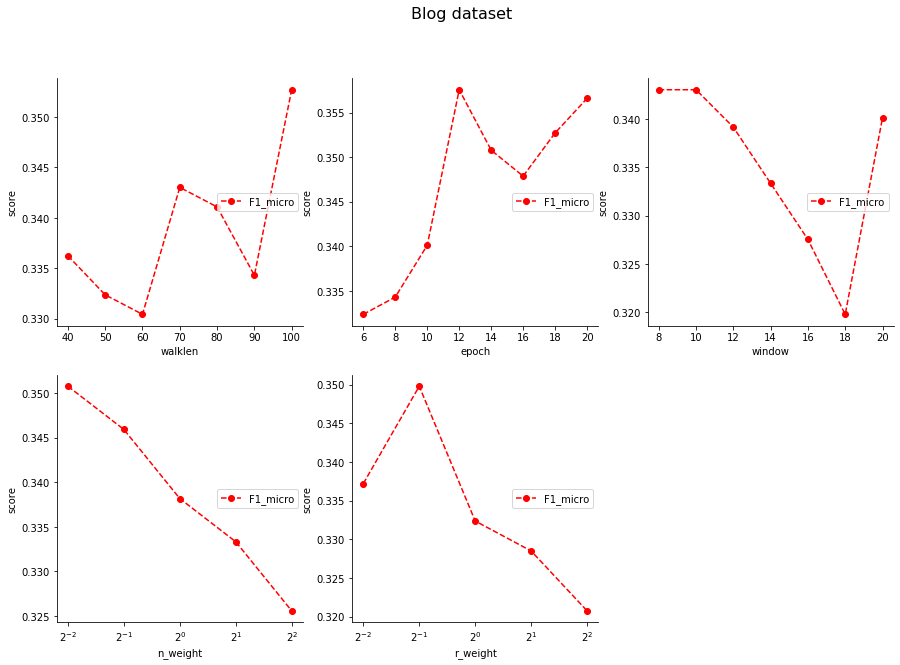

In [439]:
plt.figure(figsize=[15,10])

plt.subplot(231)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x1,bl_y1_1,'ro--', label='F1_micro')
# plt.plot(bl_x1,bl_y1_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('walklen')
plt.ylabel('score')
plt.suptitle('Blog dataset', fontsize=16)

plt.subplot(232)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x2,bl_y2_1,'ro--', label='F1_micro')
# plt.plot(bl_x2,bl_y2_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('epoch')
plt.ylabel('score')

plt.subplot(233)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x5,bl_y5_1,'ro--', label='F1_micro')
# plt.plot(bl_x5,bl_y5_2,'o-',label='RAND')
plt.legend(loc='right', frameon=True)
plt.xlabel('window')
plt.ylabel('score')


plt.subplot(234)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x3,bl_y3_1,'ro--', label='F1_micro')
# plt.plot(bl_x3,bl_y3_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='right', frameon=True)
plt.xlabel('n_weight')
plt.ylabel('score')

plt.subplot(235)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(bl_x4,bl_y4_1,'ro--', label='F1_micro')
# plt.plot(bl_x4,bl_y4_2,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='right', frameon=True)
plt.xlabel('r_weight')
plt.ylabel('score')



Same as the previous, but with f1_micro score only.

## Randomly assigned lables


In [340]:
G_blog, labels_blog = make_blogcatalog(dedupe=True)

In [367]:
y_blog = labels_blog.label
n_clusters_blog = y_blog.nunique()

In [383]:
len(y_blog)

10312

In [373]:
labels_freq = labels_blog['label'].value_counts()

In [447]:
performance = []
objects = range(1, n_clusters_blog+1)
for i in objects:
    performance.append(labels_freq[i])
y_pos = np.arange(len(objects))

plt.figure(figsize=[12,5])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of members')
plt.xlabel('Groups')
# plt.title('Number of members in groups')

plt.show()

In [347]:
from random import seed
from random import randint 

In [422]:
scores = []
for t in range(1,1000):
    random_labels = []
    for i in range(1,len(y_blog)+1):
        random_labels.append(randint(1,39))
    x = evalClusteringOnLabels(random_labels, labels.label)
    scores.append(x)


adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:      

adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0

adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score: 

adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0

adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04

adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:    

adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
a

adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:      

adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: 0.00
F-M score:       0.04
adj. MI score:   -0.00
adj. RAND score: -0.00
F-M score:       0.04


In [434]:
maxv = 0
for i in scores:
    if i[2] >= maxv:
        maxv = i[2]
        
maxv

0.036007563893680476